# 04 - Applied ML

In [200]:
# import all the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

## Cleaning the data

In [201]:
# import the data
df = pd.read_csv('CrowdstormingDataJuly1st.csv')

# save initial number of records
initial_records = df.shape[0]

# initial shape of the data
print('Initial shape of the DataFrame:', df.shape)

Initial shape of the DataFrame: (146028, 28)


In [202]:
# check which columns have NaNs
df.isnull().any()

playerShort      False
player           False
club             False
leagueCountry    False
birthday         False
height            True
weight            True
position          True
games            False
victories        False
ties             False
defeats          False
goals            False
yellowCards      False
yellowReds       False
redCards         False
photoID           True
rater1            True
rater2            True
refNum           False
refCountry       False
Alpha_3           True
meanIAT           True
nIAT              True
seIAT             True
meanExp           True
nExp              True
seExp             True
dtype: bool

We can drop the column photoID since we won't use the photos of the players.

In [203]:
df = df.drop(['photoID'], axis=1)

In [204]:
# remove records that have rater1 and/or rater2 as NaNs
df = df.dropna(axis=0, subset=['rater1', 'rater2'])

# create a new column with the mean of the two raters /  geometrical mean .... better for this kind of stuf...
df['raterMean'] = (df['rater1'] * df['rater2']) **0.5

# remove the columns rater1 and rater2
df = df.drop(['rater1', 'rater2'], axis=1)

In [205]:
df.shape

(124621, 26)

Let's now focus on the referees. As stated in [this notebook](http://nbviewer.jupyter.org/github/mathewzilla/redcard/blob/master/Crowdstorming_visualisation.ipynb), we should only take into account referees that took part in games of one of the considered leagues. This means that referees with less than 22 dyads (corresponding to the, at least, 22 players of a game) shouldn't be relevant.

In [206]:
#refs = df['refNum'].value_counts()

#df = df[df['refNum'].isin(refs[refs > 21].index)]

In [207]:
df.shape

(124621, 26)

Since we will group the records by player, the columns concerning the referees information can be removed, namely: refNum, refCountry and Alpha_3.

In [208]:
df = df.drop(['refNum', 'refCountry', 'Alpha_3'], axis=1)

Let's check again the features that have NaNs associated.

In [209]:
# check which columns have NaNs
df.isnull().any()

playerShort      False
player           False
club             False
leagueCountry    False
birthday         False
height            True
weight            True
position          True
games            False
victories        False
ties             False
defeats          False
goals            False
yellowCards      False
yellowReds       False
redCards         False
meanIAT           True
nIAT              True
seIAT             True
meanExp           True
nExp              True
seExp             True
raterMean        False
dtype: bool

In [210]:
df = df.dropna(axis=0, subset=['height', 'weight'])

records_after = df.shape[0]

By dropping the records that have NaNs in the height and weight columns we loose the following percentage of data:

In [211]:
(initial_records - records_after) / initial_records * 100

15.175171884844001

The columns nIAT, seIAT, nExp and seExp are associated with a particular referee and this information will become irrelevant as soon as the data is aggregated by players. So we'll also remove these features.

In [212]:
#df.drop(['nIAT', 'seIAT', 'nExp', 'seExp'], axis=1, inplace=True)

The same happens with the columns meanIAT and meanExp. So, for now we'll also drop them.

In [213]:
#TODO: these features seem important, we should keep them somehow
#df.drop(['meanIAT', 'meanExp'], axis=1, inplace=True)



We can remove the columns that have non-numeric data associated:

In [214]:
#TODO: should we keep the position of the player?
non_relevant = ['player', 'birthday','playerShort','club'] # deleate the club :D an keep the country .... 

df.drop(non_relevant, axis=1, inplace=True)
df.head()

leagueCountry  height  weight              position  games  victories  ties  \
0         Spain   177.0    72.0  Attacking Midfielder      1          0     0   
1        France   179.0    82.0          Right Winger      1          0     0   
5       England   182.0    71.0           Center Back      1          0     0   
6       England   187.0    80.0         Left Fullback      1          1     0   
7       England   180.0    68.0  Defensive Midfielder      1          0     0   

   defeats  goals  yellowCards  yellowReds  redCards   meanIAT   nIAT  \
0        1      0            0           0         0  0.326391  712.0   
1        1      0            1           0         0  0.203375   40.0   
5        1      0            0           0         0  0.325185  127.0   
6        0      0            0           0         0  0.325185  127.0   
7        1      0            0           0         0  0.325185  127.0   

      seIAT   meanExp   nExp     seExp  raterMean  
0  0.000564  0.396000  750.0  0.002696   0.353553  
1  0.010875 -0.204082   49.0  0.061504   0.750000  
5  0.003297  0.538462  130.0  0.013752   0.000000  
6  0.003297  0.538462  130.0  0.013752   0.000000  
7  0.003297  0.538462  130.0  0.013752   1.000000

In [215]:
df.isnull().any()

leagueCountry    False
height           False
weight           False
position          True
games            False
victories        False
ties             False
defeats          False
goals            False
yellowCards      False
yellowReds       False
redCards         False
meanIAT           True
nIAT              True
seIAT             True
meanExp           True
nExp              True
seExp             True
raterMean        False
dtype: bool

In [216]:
print('Shape of the DataFrame before aggregating by player:', df.shape)

Shape of the DataFrame before aggregating by player: (123868, 19)


In [217]:
# dealing with class features
df_features = pd.get_dummies(df,prefix = ['dummyCode_','dummyCode_'])

## Aggregating the data (by player)

In [218]:
df_features.head()

height  weight  games  victories  ties  defeats  goals  yellowCards  \
0   177.0    72.0      1          0     0        1      0            0   
1   179.0    82.0      1          0     0        1      0            1   
5   182.0    71.0      1          0     0        1      0            0   
6   187.0    80.0      1          1     0        0      0            0   
7   180.0    68.0      1          0     0        1      0            0   

   yellowReds  redCards           ...             dummyCode__Center Forward  \
0           0         0           ...                                   0.0   
1           0         0           ...                                   0.0   
5           0         0           ...                                   0.0   
6           0         0           ...                                   0.0   
7           0         0           ...                                   0.0   

   dummyCode__Center Midfielder  dummyCode__Defensive Midfielder  \
0                           0.0                              0.0   
1                           0.0                              0.0   
5                           0.0                              0.0   
6                           0.0                              0.0   
7                           0.0                              1.0   

   dummyCode__Goalkeeper  dummyCode__Left Fullback  \
0                    0.0                       0.0   
1                    0.0                       0.0   
5                    0.0                       0.0   
6                    0.0                       1.0   
7                    0.0                       0.0   

   dummyCode__Left Midfielder  dummyCode__Left Winger  \
0                         0.0                     0.0   
1                         0.0                     0.0   
5                         0.0                     0.0   
6                         0.0                     0.0   
7                         0.0                     0.0   

   dummyCode__Right Fullback  dummyCode__Right Midfielder  \
0                        0.0                          0.0   
1                        0.0                          0.0   
5                        0.0                          0.0   
6                        0.0                          0.0   
7                        0.0                          0.0   

   dummyCode__Right Winger  
0                      0.0  
1                      1.0  
5                      0.0  
6                      0.0  
7                      0.0  

[5 rows x 33 columns]

In [226]:
grouped_by_player = df_features #.groupby(['height', 'weight', 'raterMean'], as_index=False)

#clean_data = grouped_by_player.agg({'games': np.sum, 'victories': np.sum, 'ties': np.sum, 'defeats': np.sum, 'goals': np.sum,
 #                      'yellowCards': np.sum, 'yellowReds': np.sum, 'redCards': np.sum})

grouped_by_player['raterMean'].head()

0    0.353553
1    0.750000
5    0.000000
6    0.000000
7    1.000000
Name: raterMean, dtype: float64

In [234]:
Xtrain.dropna(axis=0).isnull().any()

height                             False
weight                             False
games                              False
victories                          False
ties                               False
defeats                            False
goals                              False
yellowCards                        False
yellowReds                         False
redCards                           False
meanIAT                            False
nIAT                               False
seIAT                              False
meanExp                            False
nExp                               False
seExp                              False
dummyCode__England                 False
dummyCode__France                  False
dummyCode__Germany                 False
dummyCode__Spain                   False
dummyCode__Attacking Midfielder    False
dummyCode__Center Back             False
dummyCode__Center Forward          False
dummyCode__Center Midfielder       False
dummyCode__Defen

## Training the Classifier

(123715, 32) (123715,)
1
1
1
6
6
6
11
11
11
16
16
16
21
21
21
26
26
26
31
31
31
36
36
36
41
41
41
46
46
46
10 10


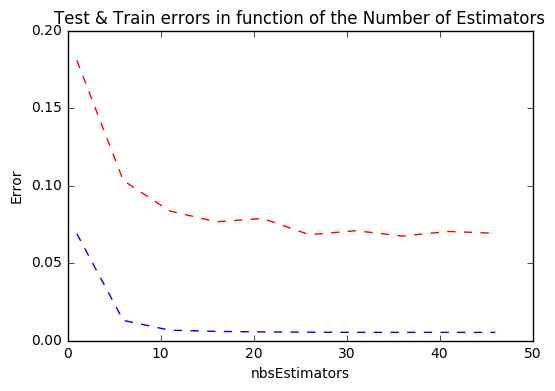

In [254]:
from sklearn.cross_validation import KFold


Xtrain = grouped_by_player.dropna(axis=0).drop(['raterMean'],axis = 1,inplace = False)
Ytrain = np.asarray(grouped_by_player.dropna(axis=0)['raterMean'], dtype="|S6")
numberOfSplit = 3
kf = KFold(Xtrain.shape[0], n_folds=numberOfSplit)

print(Xtrain.shape,Ytrain.shape)


TrainingError =[]
TestError = []
nbsEstimators = []
for i in range(1,50,5) : 
    numberOfEstimators = i
    for train_index, test_index in kf:
        print(i)
        X_train, X_test = Xtrain.iloc[train_index], Xtrain.iloc[test_index]
        Y_train, Y_test = Ytrain[train_index], Ytrain[test_index]
        
        clf = RandomForestClassifier(n_estimators=numberOfEstimators)
        clf = clf.fit(X_train, Y_train)
        train_error = 1.0 - clf.score(X_train, Y_train)
        test_error = 1.0 - clf.score(X_test,Y_test)
        train_error += train_error
        test_error += test_error
    TrainingError.append(train_error/numberOfSplit)
    TestError.append(test_error/numberOfSplit)
    nbsEstimators.append(numberOfEstimators)
        

print(len(nbsEstimators), len(TestError))

        
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(nbsEstimators, TestError, 'r--', nbsEstimators,TrainingError, 'b--')
plt.xlabel('nbsEstimators')
plt.ylabel('Error')
plt.title('Test & Train errors in function of the Number of Estimators')
plt.show()


################# GUESSSSSSSSS WHICH ONE WE TAKE ?????????? :D

Feature ranking:
1. feature 1 (0.290384)
2. feature 0 (0.274840)
3. feature 2 (0.036428)
4. feature 3 (0.033642)
5. feature 5 (0.028203)
6. feature 4 (0.024222)
7. feature 7 (0.021920)
8. feature 6 (0.019811)
9. feature 13 (0.018419)
10. feature 10 (0.017514)
11. feature 14 (0.017335)
12. feature 12 (0.017229)
13. feature 15 (0.015930)
14. feature 11 (0.015888)
15. feature 21 (0.014486)
16. feature 24 (0.014271)
17. feature 22 (0.013519)
18. feature 26 (0.011921)
19. feature 29 (0.011794)
20. feature 20 (0.011768)
21. feature 18 (0.010140)
22. feature 17 (0.009665)
23. feature 31 (0.009309)
24. feature 16 (0.008737)
25. feature 19 (0.008653)
26. feature 25 (0.008270)
27. feature 27 (0.007971)
28. feature 28 (0.007856)
29. feature 23 (0.007763)
30. feature 30 (0.007635)
31. feature 9 (0.002296)
32. feature 8 (0.002179)


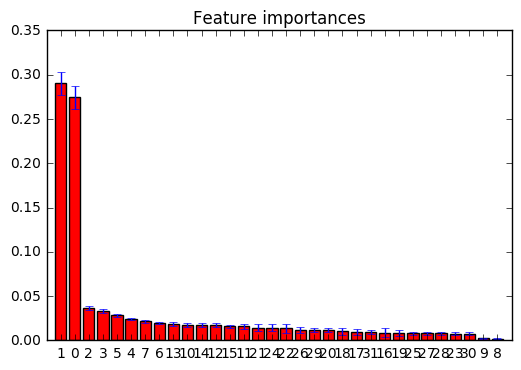

In [256]:
## features importance :

# Build a forest and compute the feature importances

Xtrain = grouped_by_player.dropna(axis=0).drop(['raterMean'],axis = 1,inplace = False)
Ytrain = np.asarray(grouped_by_player.dropna(axis=0)['raterMean'], dtype="|S6")

optimalNumberOfEstimators = 10 ### fill it !

clf = RandomForestClassifier(n_estimators=optimalNumberOfEstimators)
clf = clf.fit(Xtrain, Ytrain)
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(Xtrain.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(Xtrain.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(Xtrain.shape[1]), indices)
plt.xlim([-1, Xtrain.shape[1]])
plt.show()



In [ ]:
#### train again with only the two pictures... .write something...